Log-Gabor Filter
==========

This is an implementation of the Log-Gabor Filter.

In [2]:
# Common imports (you may not end up using all of them)
import numpy as np
import numpy.fft as fft
import scipy.ndimage as ndi
import skimage as ski
import skimage.io as io
import skimage.exposure as ex
import matplotlib.pylab as plt
import math
plt.gray() # set default to grayscale

<Figure size 432x288 with 0 Axes>

In [3]:
"""
Runs the Log-Gabor filter on an image.

Arguments:
  im the image to use the filter on.

Returns:
    the resulting image that is the output of the filter.
"""
number_scales = 5
number_orientations = 8 
N = 128 

def log_gabor_filter(f_0, theta_0):

  # dimensions of filter
  scale_bandwidth =  0.996 * math.sqrt(2/3)
  angle_bandwidth =  0.996 * (1/math.sqrt(2)) * (np.pi/number_orientations)

  extent = np.arange(-N/2, N/2 + N%2)
  x, y = np.meshgrid(extent,extent)
  mid = int(N/2)

  # orientation component
  theta = np.arctan2(y,x)
  center_angle = ((np.pi/number_orientations) * theta_0) if (f_0 % 2) \
    else ((np.pi/number_orientations) * (theta_0+0.5))
  costheta = np.cos(theta)
  sintheta = np.sin(theta)
  ds = sintheta * math.cos(center_angle) - costheta * math.sin(center_angle)    
  dc = costheta * math.cos(center_angle) + sintheta * math.sin(center_angle)  
  dtheta = np.arctan2(ds,dc)
  orientation_component =  np.exp(-0.5 * (dtheta/angle_bandwidth)**2)

  # frequency component
  raw = np.sqrt(x**2+y**2)
  raw[mid,mid] = 1
  raw = np.log2(raw)
  center_scale = math.log2(N) - f_0
  draw = raw-center_scale
  frequency_component = np.exp(-0.5 * (draw/ scale_bandwidth)**2)

  # reset origin to zero (not needed as it is already 0?)
  frequency_component[mid,mid] = 0

  return frequency_component * orientation_component

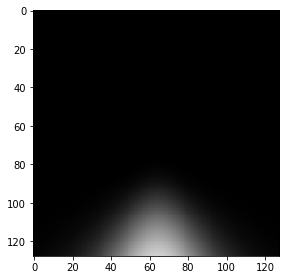

In [44]:
# for frequency in np.linspace(0, 1, num=10):
#     for direction in range(16):
#         theta = (2 * math.pi)/direction
#         plt.subplot()
io.imshow(log_gabor_filter(0.5, 20))
